In [1]:
import numpy as np
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source

In [2]:
def missing_and_unique(df, col):
    n_missing = df[col].isna().sum()
    unique_vals = df[col].unique()
    print(f'Number of missing values: {n_missing}')
    print(f'Number of unique values: {len(unique_vals)}')
    print('They are:', unique_vals)

# Pre-Processing

In [714]:
# read files
df_filtered = gpd.read_file('./data/network/trt_network_filtered.shp')
df_easy_features = gpd.read_file('./data/network/network_w_easy_features.shp')
df_twoway = gpd.read_file('./data/network/trt_network_twoway_LTS.shp')
df_twoway_vol = gpd.read_file('./data/network/trt_network_twoway_volume.shp')

In [715]:
# process the easy feature file
df_easy_features.loc[24513, 'LTS'] = 4
df_easy_features = df_easy_features[df_easy_features['length_in_'] >= 50]

In [716]:
# process filtered features
df_filtered.index = df_filtered['OBJECTID'] - 1

In [717]:
# file stats
print(f'Number of links in filtered: {len(df_filtered)}, in easy: {len(df_easy_features)}')

Number of links in filtered: 41533, in easy: 41533


In [718]:
df_filtered.columns

Index(['OBJECTID', 'GEO_ID', 'LFN_ID', 'LF_NAME', 'FNODE', 'TNODE',
       'ONE_WAY_DI', 'length_in_', 'GEO_ID_1', 'LTS', 'Shape_Leng', 'ONEWAY',
       'Shape_Le_1', 'LTS_less4', 'geometry'],
      dtype='object')

In [719]:
# re-organize the oneway colomn
df_filtered['ONEWAY'] = df_filtered['ONEWAY'].replace({'0': 0, 'F': 1, 'T': 1})

In [720]:
# join and select relevant columns
feature_cols = ['FCODE_DESC', 'SPEED', 'NBRLANES_2', 'CP_TYPE']
df = df_filtered.join(df_easy_features[feature_cols])
flags = df[(df['LTS']==1) & (df['LF_NAME'] == 'Yonge St')].index
df.loc[flags, 'CP_TYPE'] = 'Cycle Tracks'
df = df[['GEO_ID'] + feature_cols + ['ONEWAY', 'LTS']]
df.columns = ['GEO_ID', 'road_type', 'speed_limit', 'nlanes', 'infras_type', 'oneway', 'lts']
df

,GEO_ID,road_type,speed_limit,nlanes,infras_type,oneway,lts
OBJECTID,,,,,,,
0,30079678,Trail,0,0,Major Multi-use Pathway,0,1
3,30082310,Other,0,2,None,0,1
4,30008940,Trail,0,0,Major Multi-use Pathway,0,1
7,9950476,Major Arterial,60,4,None,0,3
8,7641209,Local,50,2,None,0,2
...,...,...,...,...,...,...,...
59544,14253385,Major Arterial,50,4,None,0,4
59545,107745,Major Arterial,60,5,None,0,4
59551,30113300,Other,40,2,None,0,1


In [721]:
df_twoway.columns

Index(['Join_Count', 'TARGET_FID', 'JOIN_FID', 'GEO_ID', 'LFN_ID', 'LF_NAME',
       'ADDRESS_L', 'ADDRESS_R', 'OE_FLAG_L', 'OE_FLAG_R', 'LONUML', 'HINUML',
       'LONUMR', 'HINUMR', 'FNODE', 'TNODE', 'ONE_WAY_DI', 'DIR_CODE_D',
       'FCODE', 'FCODE_DESC', 'JURIS_CODE', 'OBJECTID', 'CP_TYPE',
       'NRN_SpeedL', 'NBRLANES_2', 'Left_Parki', 'Right_Park', 'GTASpeed_1',
       'GTASpeed_2', 'GTASPeed_3', 'Shape_Leng', 'Final_Spee', 'BL_width',
       'BL_speed', 'with_parki', 'LTS_BL', 'LTS_mixed', 'LTS', 'geometry'],
      dtype='object')

In [722]:
df_twoway['parking'] = df_twoway[['Left_Parki', 'Right_Park']].values.max(axis=1)
df_twoway

,Join_Count,TARGET_FID,JOIN_FID,GEO_ID,LFN_ID,LF_NAME,ADDRESS_L,ADDRESS_R,OE_FLAG_L,OE_FLAG_R,...,Shape_Leng,Final_Spee,BL_width,BL_speed,with_parki,LTS_BL,LTS_mixed,LTS,geometry,parking
0,1,1,1,30079678,19155,Waterfront Trl,None,None,N,N,...,0.004459,0.00,0,0,0,0,0,1,"LINESTRING (-79.54478 43.58583, -79.54478 43.5...",0
1,1,2,2,30079680,19166,Marie Curtis Park Trl,None,None,N,N,...,0.000426,0.00,0,0,0,0,0,1,"LINESTRING (-79.54478 43.58583, -79.54483 43.5...",0
2,1,3,3,30079677,19155,Waterfront Trl,None,None,N,N,...,0.000375,0.00,0,0,0,0,0,1,"LINESTRING (-79.54454 43.58611, -79.54464 43.5...",0
3,1,4,4,30082310,10685,Island Rd,None,None,N,N,...,0.001771,0.00,1,0,0,0,2,2,"LINESTRING (-79.54454 43.58611, -79.54433 43.5...",0
4,1,5,5,30008940,19155,Waterfront Trl,None,None,N,N,...,0.000892,0.00,0,0,0,0,0,1,"LINESTRING (-79.54386 43.58668, -79.54400 43.5...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68666,1,59551,68667,30113299,78,Crescent Town Rd,None,None,N,N,...,0.000083,40.00,1,1,0,1,2,1,"LINESTRING (-79.29163 43.69610, -79.29157 43.6...",0
68667,1,59552,68668,30113300,11101,Crescent Pl,9-9,7-11,O,O,...,0.003167,40.00,1,1,0,1,2,2,"LINESTRING (-79.29239 43.69527, -79.29232 43.6...",0
68668,1,59553,68669,30012613,558,Dundas St W,5133-5145,5130-5146,O,E,...,0.000727,39.26,2,1,0,2,3,3,"LINESTRING (-79.53297 43.64414, -79.53346 43.6...",0
68669,1,59553,68670,30012613,558,Dundas St W,5133-5145,5130-5146,O,E,...,0.000727,41.29,2,1,0,2,4,4,"LINESTRING (-79.53297 43.64414, -79.53346 43.6...",0


In [723]:
df_twoway = df_twoway[['GEO_ID', 'NRN_SpeedL', 'Final_Spee', 'parking']]
df_twoway.columns = ['GEO_ID', 'speed_limit_verification', 'speed', 'parking']
df_twoway = df_twoway.groupby('GEO_ID').max()
df_twoway

,speed_limit_verification,speed,parking
GEO_ID,,,
108,40,40.0,0
117,40,40.0,0
118,40,40.0,0
120,40,40.0,0
121,40,40.0,0
...,...,...,...
30113710,0,0.0,0
30113711,0,0.0,0
30113820,0,0.0,0


In [724]:
df_twoway_vol.columns

Index(['Join_Count', 'TARGET_FID', 'JOIN_FID', 'GEO_ID', 'LFN_ID', 'LF_NAME',
       'ADDRESS_L', 'ADDRESS_R', 'OE_FLAG_L', 'OE_FLAG_R', 'LONUML', 'HINUML',
       'LONUMR', 'HINUMR', 'FNODE', 'TNODE', 'ONE_WAY_DI', 'DIR_CODE_D',
       'FCODE', 'FCODE_DESC', 'JURIS_CODE', 'OBJECTID', 'CP_TYPE',
       'NRN_SpeedL', 'NBRLANES_2', 'Left_Parki', 'Right_Park', 'GTASpeed_1',
       'GTASpeed_2', 'GTASPeed_3', 'Final_Spee', 'BL_width', 'BL_speed',
       'with_parki', 'LTS_BL', 'LTS_mixed', 'LTS', 'aadt_2015_', 'aadt',
       'Shape_Leng', 'aadt_max', 'Length', 'geometry'],
      dtype='object')

In [725]:
df_twoway_vol = df_twoway_vol[['GEO_ID', 'aadt_max', 'Final_Spee', 'NBRLANES_2']]
df_twoway_vol = df_twoway_vol.groupby('GEO_ID').max()
df_twoway_vol

,aadt_max,Final_Spee,NBRLANES_2
GEO_ID,,,
108,757.234130,40.0,2
117,757.214883,40.0,2
118,756.911152,40.0,2
120,757.753828,40.0,2
121,757.794105,40.0,2
...,...,...,...
30113710,499.000000,0.0,2
30113711,499.000000,0.0,2
30113820,499.000000,0.0,2


In [726]:
df_twoway = df_twoway.join(df_twoway_vol)
df_twoway

,speed_limit_verification,speed,parking,aadt_max,Final_Spee,NBRLANES_2
GEO_ID,,,,,,
108,40,40.0,0,757.234130,40.0,2
117,40,40.0,0,757.214883,40.0,2
118,40,40.0,0,756.911152,40.0,2
120,40,40.0,0,757.753828,40.0,2
121,40,40.0,0,757.794105,40.0,2
...,...,...,...,...,...,...
30113710,0,0.0,0,499.000000,0.0,2
30113711,0,0.0,0,499.000000,0.0,2
30113820,0,0.0,0,499.000000,0.0,2


In [727]:
df_twoway = df_twoway[['speed_limit_verification', 'speed', 'parking', 'aadt_max', 'NBRLANES_2']]
df_twoway.columns = ['speed_limit_verification', 'speed', 'parking', 'volume', 'n_lanes']

In [728]:
df_twoway

,speed_limit_verification,speed,parking,volume,n_lanes
GEO_ID,,,,,
108,40,40.0,0,757.234130,2
117,40,40.0,0,757.214883,2
118,40,40.0,0,756.911152,2
120,40,40.0,0,757.753828,2
121,40,40.0,0,757.794105,2
...,...,...,...,...,...
30113710,0,0.0,0,499.000000,2
30113711,0,0.0,0,499.000000,2
30113820,0,0.0,0,499.000000,2


## Actual speed

In [729]:
missing_and_unique(df_twoway, 'speed')

Number of missing values: 0
Number of unique values: 1731
They are: [40.   47.49 17.91 ... 37.35 32.75 23.11]


In [730]:
missing_and_unique(df_twoway, 'speed_limit_verification')

Number of missing values: 0
Number of unique values: 12
They are: [40 50 60  0 90 30 15 20 10 25 70 80]


In [731]:
df = df.set_index('GEO_ID')

In [732]:
df = df.join(df_twoway, how='left', rsuffix='_r')
df.reset_index(inplace=True)
df

,GEO_ID,road_type,speed_limit,nlanes,infras_type,oneway,lts,speed_limit_verification,speed,parking,volume,n_lanes
0,30079678,Trail,0,0,Major Multi-use Pathway,0,1,0,0.00,0,0.00000,0
1,30082310,Other,0,2,None,0,1,0,0.00,0,499.00000,2
2,30008940,Trail,0,0,Major Multi-use Pathway,0,1,0,0.00,0,0.00000,0
3,9950476,Major Arterial,60,4,None,0,3,60,37.62,0,16328.94334,4
4,7641209,Local,50,2,None,0,2,50,50.00,0,769.85788,2
...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Major Arterial,50,4,None,0,4,50,49.54,0,14231.03671,4
41529,107745,Major Arterial,60,5,None,0,4,60,58.89,0,15688.04148,5
41530,30113300,Other,40,2,None,0,1,40,40.00,0,499.00000,2
41531,30012613,Major Arterial,60,4,None,0,4,60,41.29,0,20070.89521,4


In [733]:
df['speed_limit'] = df['speed_limit_verification']
df['nlanes'] = df['n_lanes']
df = df[['GEO_ID', 'road_type', 'speed_limit', 'nlanes', 'infras_type', 'speed', 'oneway', 'parking', 'volume', 'lts']]
df.columns = [['geo_id', 'road_type', 'speed_limit', 'nlanes', 'infras_type', 'speed_actual', 'oneway', 'parking', 'volume', 'lts']]
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1
1,30082310,Other,0,2,None,0.00,0,0,499.00000,1
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1
3,9950476,Major Arterial,60,4,None,37.62,0,0,16328.94334,3
4,7641209,Local,50,2,None,50.00,0,0,769.85788,2
...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Major Arterial,50,4,None,49.54,0,0,14231.03671,4
41529,107745,Major Arterial,60,5,None,58.89,0,0,15688.04148,4
41530,30113300,Other,40,2,None,40.00,0,0,499.00000,1
41531,30012613,Major Arterial,60,4,None,41.29,0,0,20070.89521,4


In [734]:
# add indicators
def speed_category(speed):
    flag1 = (speed <= 40).astype(int)
    flag2 = ((speed > 40) * (speed <= 48)).astype(int) * 2
    flag3 = ((speed > 48) * (speed <= 56)).astype(int) * 3
    flag4 = (speed > 56).astype(int) * 4
    return flag1 + flag2 + flag3 + flag4 - 1

In [735]:
df.loc[df.index, 'speed_actual_cate'] = df.loc[df.index, 'speed_actual'].apply(speed_category).values
df

/var/folders/lz/p2mhxy8s7h99vl0d5qmv5ltc0000gn/T/ipykernel_40043/3318939691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index, 'speed_actual_cate'] = df.loc[df.index, 'speed_actual'].apply(speed_category).values


,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,speed_actual_cate
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0
1,30082310,Other,0,2,None,0.00,0,0,499.00000,1,0.0
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0
3,9950476,Major Arterial,60,4,None,37.62,0,0,16328.94334,3,0.0
4,7641209,Local,50,2,None,50.00,0,0,769.85788,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Major Arterial,50,4,None,49.54,0,0,14231.03671,4,1.0
41529,107745,Major Arterial,60,5,None,58.89,0,0,15688.04148,4,2.0
41530,30113300,Other,40,2,None,40.00,0,0,499.00000,1,1.0
41531,30012613,Major Arterial,60,4,None,41.29,0,0,20070.89521,4,1.0


In [736]:
speed_cate = pd.get_dummies(df['speed_actual_cate'].values.reshape(-1).astype(str)).astype(int)
df = pd.concat([df, speed_cate], axis=1)
df

,"(geo_id,)","(road_type,)","(speed_limit,)","(nlanes,)","(infras_type,)","(speed_actual,)","(oneway,)","(parking,)","(volume,)","(lts,)","(speed_actual_cate,)",0.0,1.0,2.0
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0
1,30082310,Other,0,2,None,0.00,0,0,499.00000,1,0.0,1,0,0
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0
3,9950476,Major Arterial,60,4,None,37.62,0,0,16328.94334,3,0.0,1,0,0
4,7641209,Local,50,2,None,50.00,0,0,769.85788,2,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Major Arterial,50,4,None,49.54,0,0,14231.03671,4,1.0,0,1,0
41529,107745,Major Arterial,60,5,None,58.89,0,0,15688.04148,4,2.0,0,0,1
41530,30113300,Other,40,2,None,40.00,0,0,499.00000,1,1.0,0,1,0
41531,30012613,Major Arterial,60,4,None,41.29,0,0,20070.89521,4,1.0,0,1,0


In [737]:
df.columns = ['geo_id', 'road_type', 'speed_limit', 'nlanes', 'infras_type', 'speed_actual', 'oneway', 'parking', 'volume', 'lts', 'speed_actual_cate', 'speed_ac_1', 'speed_ac_2', 'speed_ac_3']
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,speed_actual_cate,speed_ac_1,speed_ac_2,speed_ac_3
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0
1,30082310,Other,0,2,None,0.00,0,0,499.00000,1,0.0,1,0,0
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0
3,9950476,Major Arterial,60,4,None,37.62,0,0,16328.94334,3,0.0,1,0,0
4,7641209,Local,50,2,None,50.00,0,0,769.85788,2,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Major Arterial,50,4,None,49.54,0,0,14231.03671,4,1.0,0,1,0
41529,107745,Major Arterial,60,5,None,58.89,0,0,15688.04148,4,2.0,0,0,1
41530,30113300,Other,40,2,None,40.00,0,0,499.00000,1,1.0,0,1,0
41531,30012613,Major Arterial,60,4,None,41.29,0,0,20070.89521,4,1.0,0,1,0


In [738]:
# deal with the index issue
df.to_csv('./data/network/intermediate.csv', index=False)
df = pd.read_csv('./data/network/intermediate.csv')

## Road Type

In [740]:
# road type column
missing_and_unique(df, 'road_type')

Number of missing values: 0
Number of unique values: 15
They are: ['Trail' 'Other' 'Major Arterial' 'Local' 'Collector' 'Laneway' 'Walkway'
 'Minor Arterial' 'Pending' 'Major Arterial Ramp' 'Access Road'
 'Collector Ramp' 'Other Ramp' 'Busway' 'Minor Arterial Ramp']


In [741]:
pd.get_dummies(df['road_type']).sum()

Access Road               30
Busway                     7
Collector               5147
Collector Ramp            13
Laneway                 2535
Local                  20378
Major Arterial          4581
Major Arterial Ramp      157
Minor Arterial          2664
Minor Arterial Ramp        1
Other                   1242
Other Ramp                11
Pending                  418
Trail                   4155
Walkway                  194
dtype: int64

In [742]:
# replace
road_type_mapping = {'Major Arterial': 'Arterial', 
                     'Minor Arterial': 'Arterial', 
                     'Major Arterial Ramp': 'Arterial', 
                     'Minor Arterial Ramp': 'Arterial',
                     'Collector Ramp': 'Local', 
                     'Collector': 'Local',
                     'Access Road': 'Local',
                     'Laneway': 'Local',
                     'Other Ramp': 'Other', 
                     'Busway': 'Other',
                     'Pending': 'Other',
                     'Walkway': 'Trail'}
df['road_type'].replace(road_type_mapping, inplace=True)
missing_and_unique(df, 'road_type')

Number of missing values: 0
Number of unique values: 4
They are: ['Trail' 'Other' 'Arterial' 'Local']


In [743]:
pd.get_dummies(df['road_type']).sum()

Arterial     7403
Local       28103
Other        1678
Trail        4349
dtype: int64

In [744]:
# one-hot-encoding
df = pd.concat([df, pd.get_dummies(df['road_type'])], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,speed_actual_cate,speed_ac_1,speed_ac_2,speed_ac_3,Arterial,Local,Other,Trail
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0,0,0,0,1
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,0.0,1,0,0,0,0,1,0
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,0.0,1,0,0,0,0,0,1
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,0.0,1,0,0,1,0,0,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,1.0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,1.0,0,1,0,1,0,0,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,2.0,0,0,1,1,0,0,0
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,1.0,0,1,0,0,0,1,0
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,1.0,0,1,0,1,0,0,0


## Speed limit

In [745]:
missing_and_unique(df, 'speed_limit')

Number of missing values: 0
Number of unique values: 11
They are: [ 0 60 50 40 20 30 10 70 80 15 25]


In [746]:
speed_lmt_cate = pd.get_dummies(df['speed_limit'])
speed_lmt_cate.columns = [f'speed_{s}' for s in [0, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]]
df = pd.concat([df, speed_lmt_cate], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,speed_10,speed_15,speed_20,speed_25,speed_30,speed_40,speed_50,speed_60,speed_70,speed_80
0,30079678,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,0,0,0,0,0,0
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,0,0,0,0,0,0,0,0
2,30008940,Trail,0,0,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,0,0,0,0,0,0
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,0,0,0,0,0,0,1,0,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,0,0,0,0,0,1,0,0,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,0,0,0,0,0,1,0,0
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,0,0,0,0,1,0,0,0,0
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,0,0,0,0,0,0,1,0,0


## nlanes

In [747]:
missing_and_unique(df, 'nlanes')

Number of missing values: 0
Number of unique values: 11
They are: [ 0  2  4  5  6  3  1  7 21  8 44]


In [748]:
df['nlanes'] = df['nlanes'].replace({44: 4, 21: 2, 0: 1})
missing_and_unique(df, 'nlanes')

Number of missing values: 0
Number of unique values: 8
They are: [1 2 4 5 6 3 7 8]


In [749]:
pd.get_dummies(df['nlanes']).sum()

1     8055
2    27554
3      277
4     4022
5      855
6      613
7      143
8       14
dtype: int64

In [750]:
# further group
df['nlanes'] = df['nlanes'].replace({6: 5, 7: 5, 8: 5})
missing_and_unique(df, 'nlanes')

Number of missing values: 0
Number of unique values: 5
They are: [1 2 4 5 3]


In [751]:
pd.get_dummies(df['nlanes']).sum()

1     8055
2    27554
3      277
4     4022
5     1625
dtype: int64

In [752]:
nlanes_onehot = pd.get_dummies(df['nlanes'])
nlanes_onehot.columns = ['nlanes_1', 'nlanes_2', 'nlanes_3', 'nlanes_4', 'nlanes_5']
df = pd.concat([df, nlanes_onehot], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,speed_40,speed_50,speed_60,speed_70,speed_80,nlanes_1,nlanes_2,nlanes_3,nlanes_4,nlanes_5
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,0,1,0,0,0,0
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,0,0,0,0,1,0,0,0
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,0,1,0,0,0,0
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,0,1,0,0,0,0,0,1,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,1,0,0,0,0,0,0,1,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,1,0,0,0,0,0,0,1
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,1,0,0,0,0,0,1,0,0,0
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,0,1,0,0,0,0,0,1,0


# infras type

In [753]:
missing_and_unique(df, 'infras_type')

Number of missing values: 36817
Number of unique values: 10
They are: ['Major Multi-use Pathway' nan 'Suggested On-Street Routes'
 'Signed Routes' 'Bike Lanes' 'Park Roads Cycling Connections'
 'Minor Multi-use Pathway' 'Quiet Street Cycling Routes' 'Cycle Tracks'
 'Informal Dirt Footpath']


In [754]:
cp_mapping = {val: 'No Infras' for val in df['infras_type'].unique()}
cp_mapping['Bike Lanes'] = 'Bike Lanes'
cp_mapping['Cycle Tracks'] = 'Cycle Tracks'
cp_mapping['Major Multi-use Pathway'] = 'Multi-use Pathway'
cp_mapping['Minor Multi-use Pathway'] = 'Multi-use Pathway'
cp_mapping['Informal Dirt Footpath'] = 'Multi-use Pathway'
cp_mapping['Park Roads Cycling Connections'] = 'Multi-use Pathway'

df['sim_infras_type'] = df['infras_type'].replace(cp_mapping)
df.index = range(len(df))
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,speed_50,speed_60,speed_70,speed_80,nlanes_1,nlanes_2,nlanes_3,nlanes_4,nlanes_5,sim_infras_type
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,1,0,0,0,0,Multi-use Pathway
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,0,0,0,1,0,0,0,No Infras
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,0,1,0,0,0,0,Multi-use Pathway
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,1,0,0,0,0,0,1,0,No Infras
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,1,0,0,0,0,1,0,0,0,No Infras
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,1,0,0,0,0,0,0,1,0,No Infras
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,1,0,0,0,0,0,0,1,No Infras
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,0,0,0,0,1,0,0,0,No Infras
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,1,0,0,0,0,0,1,0,No Infras


In [755]:
df = pd.concat([df, pd.get_dummies(df['sim_infras_type'])], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,nlanes_1,nlanes_2,nlanes_3,nlanes_4,nlanes_5,sim_infras_type,Bike Lanes,Cycle Tracks,Multi-use Pathway,No Infras
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,1,0,0,0,0,Multi-use Pathway,0,0,1,0
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,1,0,0,0,No Infras,0,0,0,1
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,1,0,0,0,0,Multi-use Pathway,0,0,1,0
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,0,0,1,0,No Infras,0,0,0,1
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,1,0,0,0,No Infras,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,0,0,1,0,No Infras,0,0,0,1
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,0,0,1,No Infras,0,0,0,1
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,1,0,0,0,No Infras,0,0,0,1
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,0,0,1,0,No Infras,0,0,0,1


## Oneway

In [756]:
oneway = pd.get_dummies(df['oneway'].replace({1: 'oneway_indi', 0: 'twoway_indi'}))
df = pd.concat([df, oneway], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,nlanes_3,nlanes_4,nlanes_5,sim_infras_type,Bike Lanes,Cycle Tracks,Multi-use Pathway,No Infras,oneway_indi,twoway_indi
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,Multi-use Pathway,0,0,1,0,0,1
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,0,No Infras,0,0,0,1,0,1
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,0,0,Multi-use Pathway,0,0,1,0,0,1
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,1,0,No Infras,0,0,0,1,0,1
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,0,0,No Infras,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,1,0,No Infras,0,0,0,1,0,1
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,1,No Infras,0,0,0,1,0,1
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,0,0,No Infras,0,0,0,1,0,1
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,1,0,No Infras,0,0,0,1,0,1


In [757]:
df[['oneway_indi', 'twoway_indi']].sum()

oneway_indi     2415
twoway_indi    39118
dtype: int64

## Parking

In [758]:
parking = pd.get_dummies(df['parking'].replace({1: 'parking_indi', 0: 'noparking_indi'}))
parking.sum()

noparking_indi    39856
parking_indi       1677
dtype: int64

In [759]:
df = pd.concat([df, parking], axis=1)
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,nlanes_5,sim_infras_type,Bike Lanes,Cycle Tracks,Multi-use Pathway,No Infras,oneway_indi,twoway_indi,noparking_indi,parking_indi
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,Multi-use Pathway,0,0,1,0,0,1,1,0
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,No Infras,0,0,0,1,0,1,1,0
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,Multi-use Pathway,0,0,1,0,0,1,1,0
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,No Infras,0,0,0,1,0,1,1,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,No Infras,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,No Infras,0,0,0,1,0,1,1,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,1,No Infras,0,0,0,1,0,1,1,0
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,No Infras,0,0,0,1,0,1,1,0
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,No Infras,0,0,0,1,0,1,1,0


## Volume

In [760]:
df['volume_type'] = (df['volume'] < 3000).replace({True: 'low', False: 'high'})
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,sim_infras_type,Bike Lanes,Cycle Tracks,Multi-use Pathway,No Infras,oneway_indi,twoway_indi,noparking_indi,parking_indi,volume_type
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,Multi-use Pathway,0,0,1,0,0,1,1,0,low
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,No Infras,0,0,0,1,0,1,1,0,low
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,Multi-use Pathway,0,0,1,0,0,1,1,0,low
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,No Infras,0,0,0,1,0,1,1,0,high
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,No Infras,0,0,0,1,0,1,1,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,No Infras,0,0,0,1,0,1,1,0,high
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,No Infras,0,0,0,1,0,1,1,0,high
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,No Infras,0,0,0,1,0,1,1,0,low
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,No Infras,0,0,0,1,0,1,1,0,high


In [761]:
volume_type = pd.get_dummies(df['volume_type'])
df = pd.concat([df, volume_type], axis=1)

In [762]:
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,Cycle Tracks,Multi-use Pathway,No Infras,oneway_indi,twoway_indi,noparking_indi,parking_indi,volume_type,high,low
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,1,0,0,1,1,0,low,0,1
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,1,0,1,1,0,low,0,1
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,1,0,0,1,1,0,low,0,1
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,0,1,0,1,1,0,high,1,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,0,1,0,1,1,0,low,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,0,1,0,1,1,0,high,1,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,1,0,1,1,0,high,1,0
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,0,1,0,1,1,0,low,0,1
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,0,1,0,1,1,0,high,1,0


In [763]:
volume_type.sum()

high    12019
low     29514
dtype: int64

# Re-do Speed

In [108]:
def speed_category(speed):
    flag1 = (speed <= 40).astype(int)
    flag2 = ((speed > 40) * (speed <= 48)).astype(int) * 2
    flag3 = ((speed > 48) * (speed <= 56)).astype(int) * 3
    flag4 = (speed > 56).astype(int) * 4
    return flag1 + flag2 + flag3 + flag4 - 1

df_tmp = pd.get_dummies(df.loc[:, ['speed_actual']].apply(speed_category).values.reshape(-1).astype(str))
speed_actual_onehot = df_tmp.values
np.savetxt('./data/road/speed_actual_onehot.txt', speed_actual_onehot, delimiter=',')

In [110]:
speed_actual_onehot.sum(axis=0).max()/len(speed_actual_onehot)

0.5448438590999928

# Save data

In [3]:
# df.to_csv('./data/network/final.csv', index=False)

In [61]:
infras_onehot

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [2]:
df = pd.read_csv('./data/network/final.csv')

In [62]:
road_type_onehot = df[['Arterial', 'Local', 'Other', 'Trail']].values
n_lanes_onehot = df[['nlanes_1', 'nlanes_2', 'nlanes_3', 'nlanes_4', 'nlanes_5']].values
infras_onehot = df[['Bike Lanes', 'Cycle Tracks', 'Multi-use Pathway', 'No Infras']].values
# speed_actual_onehot = speed_actual_onehot = df[['speed_ac_1', 'speed_ac_2', 'speed_ac_3']].values
oneway_onehot = df[['oneway_indi', 'twoway_indi']].values
oneway = df['oneway'].values
parking_onehot = df[['parking_indi', 'noparking_indi']].values
volume_onehot = df[['low', 'high']].values
speed_limit = df['speed_limit'].values

In [63]:
np.savetxt('./data/road/road_type_onehot.txt', road_type_onehot, delimiter=',')
np.savetxt('./data/road/n_lanes_onehot.txt', n_lanes_onehot, delimiter=',')
np.savetxt('./data/road/cyc_infras_onehot.txt', infras_onehot, delimiter=',')
# np.savetxt('./data/road/speed_actual_onehot.txt', speed_actual_onehot, delimiter=',')
np.savetxt('./data/road/oneway_onehot.txt', oneway_onehot, delimiter=',')
np.savetxt('./data/road/oneway.txt', oneway, delimiter=',')
np.savetxt('./data/road/parking_onehot.txt', parking_onehot, delimiter=',')
np.savetxt('./data/road/volume_onehot.txt', volume_onehot, delimiter=',')

In [932]:
# np.savetxt('./data/LTS/lts_labels.txt', df['lts'].values, delimiter=',')

# Load data

In [9]:
df = pd.read_csv('./data/network/final.csv')
df

,geo_id,road_type,speed_limit,nlanes,infras_type,speed_actual,oneway,parking,volume,lts,...,Cycle Tracks,Multi-use Pathway,No Infras,oneway_indi,twoway_indi,noparking_indi,parking_indi,volume_type,high,low
0,30079678,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,1,0,0,1,1,0,low,0,1
1,30082310,Other,0,2,NaN,0.00,0,0,499.00000,1,...,0,0,1,0,1,1,0,low,0,1
2,30008940,Trail,0,1,Major Multi-use Pathway,0.00,0,0,0.00000,1,...,0,1,0,0,1,1,0,low,0,1
3,9950476,Arterial,60,4,NaN,37.62,0,0,16328.94334,3,...,0,0,1,0,1,1,0,high,1,0
4,7641209,Local,50,2,NaN,50.00,0,0,769.85788,2,...,0,0,1,0,1,1,0,low,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,14253385,Arterial,50,4,NaN,49.54,0,0,14231.03671,4,...,0,0,1,0,1,1,0,high,1,0
41529,107745,Arterial,60,5,NaN,58.89,0,0,15688.04148,4,...,0,0,1,0,1,1,0,high,1,0
41530,30113300,Other,40,2,NaN,40.00,0,0,499.00000,1,...,0,0,1,0,1,1,0,low,0,1
41531,30012613,Arterial,60,4,NaN,41.29,0,0,20070.89521,4,...,0,0,1,0,1,1,0,high,1,0


# Naive Attri Pred Baseline

In [767]:
def eval_naive_prediction(vals):
    return np.max(vals.sum(axis=0)) / len(vals)

In [768]:
# road type
eval_naive_prediction(road_type_onehot)

0.6766426696843474

In [769]:
# Cyc Infras
eval_naive_prediction(infras_onehot)

0.9318854886475815

In [770]:
# n lanes onehot
eval_naive_prediction(n_lanes_onehot)

0.6634242650422556

In [771]:
# speed actual
eval_naive_prediction(speed_actual_onehot)

0.7329352563022176

In [772]:
# oneway
eval_naive_prediction(oneway_onehot)

0.941853465918667

In [773]:
# parking
eval_naive_prediction(parking_onehot)

0.9596224688801676

In [774]:
# volume
eval_naive_prediction(volume_onehot)

0.7106156550213084

In [775]:
df.columns

Index(['geo_id', 'road_type', 'speed_limit', 'nlanes', 'infras_type',
       'speed_actual', 'oneway', 'parking', 'volume', 'lts',
       'speed_actual_cate', 'speed_ac_1', 'speed_ac_2', 'speed_ac_3',
       'Arterial', 'Local', 'Other', 'Trail', 'speed_0', 'speed_10',
       'speed_15', 'speed_20', 'speed_25', 'speed_30', 'speed_40', 'speed_50',
       'speed_60', 'speed_70', 'speed_80', 'nlanes_1', 'nlanes_2', 'nlanes_3',
       'nlanes_4', 'nlanes_5', 'sim_infras_type', 'Bike Lanes', 'Cycle Tracks',
       'Multi-use Pathway', 'No Infras', 'oneway_indi', 'twoway_indi',
       'noparking_indi', 'parking_indi', 'volume_type', 'high', 'low'],
      dtype='object')

# Train Test Split

In [32]:
def load_data(df, features, w_volume=True):
    f2c = {'speed_actual_onehot': ['speed_ac_1', 'speed_ac_2', 'speed_ac_3'], 
           'speed_actual': ['speed_actual'],
           'nlanes_onehot': ['nlanes_1', 'nlanes_2', 'nlanes_3', 'nlanes_4', 'nlanes_5'],
           'nlanes': ['nlanes'],
           'road_type': ['Arterial', 'Local', 'Other', 'Trail'],
           'infras': ['Bike Lanes', 'Cycle Tracks', 'Multi-use Pathway', 'No Infras'],
           'parking': ['parking_indi', 'noparking_indi'],
           'oneway': ['oneway_indi', 'twoway_indi'], 
           'volume_onehot': ['high', 'low'],
           'volume': ['volume'],
           'speed_limit': ['speed_limit']
          }
    cols = []
    for f in features:
        cols += f2c[f]
    if w_volume:
        return df[cols], df['lts']
    else:
        return df[cols], pd.DataFrame({'lts': np.loadtxt('./data/LTS/lts_labels_wo_volume.txt').reshape(-1)})['lts']

In [5]:
def load_emb(encoder_name, purpose):
    root = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/AutoLTS/'
    X = np.loadtxt(f'{root}/emb/{encoder_name}_{purpose}.txt', delimiter=',').astype(float)
    y = np.loadtxt(f'{root}/data/LTS/lts_labels.txt').astype(int)
    indi = np.loadtxt(f'{root}/data/{purpose}_idx.txt').astype(int)
    y = y[indi]
    return X, y

In [5]:
indi_train = np.loadtxt(f'./data/training_idx.txt').astype(int)
indi_vali = np.loadtxt(f'./data/validation_idx.txt').astype(int)
# indi_train = np.concatenate([indi_train, indi_vali])
indi_test = np.loadtxt(f'./data/test_idx.txt').astype(int)

In [6]:
def model_eval(y_true, y_pred):
    # acc
    acc = (y_pred == y_true).sum() / y_true.shape[0] * 100
    # h/l acc
    flag_pred = (y_pred <= 2)
    flag_true = (y_true <= 2)
    hl_acc = (flag_pred == flag_true).sum() / y_true.shape[0] * 100
    # mae
    mae = np.abs(y_true - y_pred).mean()
    # mse
    mse = ((y_true - y_pred) ** 2).mean()
    # kt
    pred_mat = np.sign(y_pred.reshape((-1, 1)) - y_pred.reshape((1, -1)))
    true_mat = np.sign(y_true.reshape((-1, 1)) - y_true.reshape((1, -1)))
    kt = ((pred_mat == true_mat).sum() - y_true.shape[0])/2
    kt /= ((y_pred.shape[0] - 1)** 2)
    # flr
    n_high_stress = (y_true >= 3).sum()
    false_low_stress = ((y_pred <= 2) * (y_true >= 3)).sum()
    flr = false_low_stress / n_high_stress * 100
    # fhr
    n_low_stress = (y_true <= 2).sum()
    false_high_stress = ((y_pred >= 3) * (y_true <= 2)).sum()
    fhr = false_high_stress / n_low_stress * 100
    # record generation
    return pd.Series([acc, hl_acc, flr, fhr, (flr + fhr) /2, kt], index=['Accuracy', 'H/L Accuracy', 'FLR', 'FHR', 'AFR', 'KT']).round(2)

## Exact Mapping

In [780]:
df.columns

Index(['geo_id', 'road_type', 'speed_limit', 'nlanes', 'infras_type',
       'speed_actual', 'oneway', 'parking', 'volume', 'lts',
       'speed_actual_cate', 'speed_ac_1', 'speed_ac_2', 'speed_ac_3',
       'Arterial', 'Local', 'Other', 'Trail', 'speed_0', 'speed_10',
       'speed_15', 'speed_20', 'speed_25', 'speed_30', 'speed_40', 'speed_50',
       'speed_60', 'speed_70', 'speed_80', 'nlanes_1', 'nlanes_2', 'nlanes_3',
       'nlanes_4', 'nlanes_5', 'sim_infras_type', 'Bike Lanes', 'Cycle Tracks',
       'Multi-use Pathway', 'No Infras', 'oneway_indi', 'twoway_indi',
       'noparking_indi', 'parking_indi', 'volume_type', 'high', 'low'],
      dtype='object')

In [97]:
def lts_prediction(df):
    # initialize
    lane_div = 2 - df['oneway'] 
    if df['Trail'] == 1 or df['Cycle Tracks'] == 1 or df['Multi-use Pathway'] == 1:
        return 1
    if df['Bike Lanes'] == 1:
        if df['parking_indi'] == 1:
            if df['nlanes'] / lane_div <= 1:
                if df['speed_actual'] <= 40:
                    return 1
                elif df['speed_actual'] <= 48:
                    return 2
                elif df['speed_actual'] <= 56:
                    return 3
                else:
                    return 4
            else:
                if df['speed_actual'] <= 56:
                    return 3
                else:
                    return 4
        else:
            if df['nlanes'] / lane_div <= 1:
                if df['speed_actual'] <= 48:
                    return 1
                elif df['speed_actual'] <= 56:
                    return 3
                else:
                    return 4
            elif df['nlanes'] / lane_div <= 2:
                if df['speed_actual'] <= 48:
                    return 2
                elif df['speed_actual'] <= 56:
                    return 3
                else:
                    return 4
            else:
                if df['speed_actual'] <= 56:
                    return 3
                else:
                    return 4
    else:
        if df['nlanes'] <= 3:
            if df['speed_actual'] <= 40:
                if df['volume'] <= 3000 and df['Arterial'] != 1:
                    return 1
                else:
                    return 2
            elif df['speed_actual'] <= 56:
                if df['volume'] <= 3000 and df['Arterial'] != 1:
                    return 2
                else:
                    return 3
            else:
                return 4
        elif df['nlanes'] <= 5:
            if df['speed_actual'] <= 40:
                return 3
            else:
                return 4
        else:
            return 4

In [102]:
df_pred = pd.concat([df['lts'], df.apply(lts_prediction, axis=1)], axis=1)
df_pred.columns = ['true', 'pred']

In [103]:
(df_pred['true'] == df_pred['pred']).sum() / len(df_pred)

1.0

In [104]:
confusion_matrix(df_pred['true'], df_pred['pred'], normalize='true').round(2)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

# CART - everything

In [13]:
X, y = load_data(df, ['infras', 'road_type', 'speed_actual', 'nlanes', 'parking', 'oneway', 'volume'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [14]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.99880810488677)

In [15]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true')

array([[0.99834369, 0.        , 0.        , 0.00165631],
       [0.        , 1.        , 0.        , 0.        ],
       [0.00246002, 0.00123001, 0.99630996, 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [16]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        99.88
H/L Accuracy    99.88
FLR              0.21
FHR              0.09
KT               0.50
dtype: float64

# CART - speed actual + n lanes

In [25]:
X, y = load_data(df, ['speed_limit', 'nlanes'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [40]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8691210274747327, 0.8631023327090073)

In [41]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true').round(2)

array([[0.99, 0.  , 0.  , 0.  ],
       [0.17, 0.82, 0.  , 0.  ],
       [0.  , 0.49, 0.5 , 0.01],
       [0.  , 0.  , 0.  , 1.  ]])

In [42]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        86.31
H/L Accuracy    92.66
FLR             28.70
FHR              0.67
KT               0.43
dtype: float64

In [33]:
X, y = load_data(df, ['speed_limit', 'nlanes'], w_volume=False)
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9129054621082205, 0.9078835348203643)

In [34]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true').round(2)

array([[0.98, 0.01, 0.  , 0.01],
       [0.02, 0.97, 0.  , 0.01],
       [0.1 , 0.18, 0.14, 0.58],
       [0.01, 0.02, 0.03, 0.95]])

In [35]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        90.79
H/L Accuracy    96.83
FLR             13.77
FHR              0.85
AFR              7.31
KT               0.47
dtype: float64

# CART - speed limit + lanes

In [43]:
X, y = load_data(df, ['speed_limit', 'nlanes'], w_volume=False)
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [44]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9129054621082205, 0.9078835348203643)

In [45]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true').round(2)

array([[0.98, 0.01, 0.  , 0.01],
       [0.02, 0.97, 0.  , 0.01],
       [0.1 , 0.18, 0.14, 0.58],
       [0.01, 0.02, 0.03, 0.95]])

In [46]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        90.79
H/L Accuracy    96.83
FLR             13.77
FHR              0.85
AFR              7.31
KT               0.47
dtype: float64

## Grid Search

In [48]:
dt_clf = DecisionTreeClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]}

clf = GridSearchCV(dt_clf, params, cv=10)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 0.01}

In [49]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=6, min_samples_split=0.01)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9128324880504981, 0.90737272262898)

In [51]:
model_eval(y_test.values, dt_clf.predict(X_test))

Accuracy        90.74
H/L Accuracy    96.83
FLR             13.77
FHR              0.85
AFR              7.31
KT               0.47
dtype: float64

# CART -  road type + cyc infras + oneway

In [24]:
X, y = load_data(df, ['infras', 'road_type', 'oneway'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [25]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.54679461451454, 0.5472501277030478)

In [26]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true').round(2)

array([[0.3 , 0.7 , 0.  , 0.  ],
       [0.02, 0.93, 0.01, 0.04],
       [0.03, 0.44, 0.06, 0.46],
       [0.01, 0.07, 0.03, 0.89]])

In [39]:
X, y = load_data(df, ['infras', 'road_type', 'oneway'], w_volume=False)
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [40]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5641989272813515, 0.562233951983654)

In [41]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true').round(2)

array([[0.97, 0.03, 0.  , 0.  ],
       [0.91, 0.05, 0.01, 0.04],
       [0.08, 0.01, 0.1 , 0.81],
       [0.08, 0.01, 0.03, 0.88]])

In [42]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        56.22
H/L Accuracy    96.87
FLR              8.45
FHR              1.97
AFR              5.21
KT               0.31
dtype: float64

## Grid Search

In [27]:
dt_clf = DecisionTreeClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]}

clf = GridSearchCV(dt_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.01}

In [28]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=5, min_samples_split=0.01)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5467581274856789, 0.5470798569725864)

In [29]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        54.71
H/L Accuracy    91.01
FLR             30.99
FHR              2.12
AFR             16.56
KT               0.30
dtype: float64

# Random Forest - speed + nlanes

## Naive

In [17]:
X, y = load_data(df, ['speed_limit', 'nlanes'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [18]:
clf = RandomForestClassifier(random_state=0, n_estimators=50, max_depth=6)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8063633378334002, 0.8001021624382768)

In [19]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        80.01
H/L Accuracy    91.08
FLR             34.36
FHR              0.98
AFR             17.67
KT               0.41
dtype: float64

## Grid Search

In [21]:
rf_clf = RandomForestClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
          'max_features': ['sqrt', 'log2'],
          'n_estimators': [10, 30, 50, 70, 100]}

clf = GridSearchCV(rf_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 0.01,
 'n_estimators': 100}

In [22]:
clf = RandomForestClassifier(random_state=0, n_estimators=100, max_features='sqrt', min_samples_split=0.01, max_depth=5, criterion='gini')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8060714416025103, 0.7995913502468925)

In [23]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        79.96
H/L Accuracy    91.08
FLR             34.22
FHR              1.03
AFR             17.62
KT               0.41
dtype: float64

# Random Forest - road type + cyc infras + oneway

## Naive

In [30]:
X, y = load_data(df, ['infras', 'road_type', 'oneway'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [31]:
clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.54679461451454, 0.5470798569725864)

## Grid Search

In [33]:
rf_clf = RandomForestClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
          'max_features': ['sqrt', 'log2'],
          'n_estimators': [10, 30, 50, 70, 100]}

clf = GridSearchCV(rf_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_split': 0.01,
 'n_estimators': 10}

In [34]:
clf = RandomForestClassifier(random_state=0, n_estimators=10, max_features='sqrt', min_samples_split=0.01, max_depth=6, criterion='gini')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5467581274856789, 0.5469095862421249)

In [35]:
model_eval(y_test.values, clf.predict(X_test))

Accuracy        54.69
H/L Accuracy    90.99
FLR             30.99
FHR              2.14
AFR             16.57
KT               0.30
dtype: float64

# Mask Former Pred

In [ ]:
def check_attri_pred(file_name, label='lts'):
    # load data
    res = torch.load(root + f'{file_name}_res.pt')
    # visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax_cbar = fig.add_axes([0.93, 0.13, 0.02, 0.75])
    records = []
    for idx, dataset in enumerate(['training', 'validation', 'test']):
        # extract
        data = res[dataset]['conf_mat'] * 100
        acc = res[dataset]['accuracy']
        aggacc = res[dataset]['aggregated_accuracy']
        mae = res[dataset]['mae']
        mse = res[dataset]['mse']
        ob = res[dataset]['ob']
        kt = res[dataset]['kt'] if dataset == 'training' else res[dataset]['kt']
        sns.heatmap(data, ax=ax[idx], annot=True, cmap=sns.light_palette("seagreen", reverse=False), 
                    vmin=0, vmax=100, annot_kws={'fontsize':22}, cbar_ax=ax_cbar)
        ax[idx].set_title(f'{dataset} (accuracy {acc:.2f}%)', size=20)
        if label == 'road_type_onehot':
            ax[idx].set_xticks([0.5, 1.5, 2.5, 3.5], ['Arterial', 'Local', 'Others', 'Trail'], size=20)
            ax[idx].set_yticks([0.5, 1.5, 2.5, 3.5], ['Arterial', 'Local', 'Others', 'Trail'], size=20)
        elif label == 'volume_onehot':
            ax[idx].set_xticks([0.5, 1.5], ['Low', 'High'], size=20)
            ax[idx].set_yticks([0.5, 1.5], ['Low', 'High'], size=20)
        elif label == 'n_lanes_onehot':
            ax[idx].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], [1, 2, 3, 4, '>4'], size=20)
            ax[idx].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], [1, 2, 3, 4, '>4'], size=20)
        elif label == 'speed_actual_onehot':
            ax[idx].set_xticks([0.5, 1.5, 2.5], ['Low', 'Mid', 'High'], size=20)
            ax[idx].set_yticks([0.5, 1.5, 2.5], ['Low', 'Mid', 'High'], size=20)
        else:
            ax[idx].set_xticks([0.5, 1.5, 2.5, 3.5], ['LTS1', 'LTS2', 'LTS3', 'LTS4'], size=20)
            ax[idx].set_yticks([0.5, 1.5, 2.5, 3.5], ['LTS1', 'LTS2', 'LTS3', 'LTS4'], size=20)
        ax[idx].set_xlabel('Predicted Label', size=20)
        if idx == 0:
            ax[idx].set_ylabel('True Label', size=25)
        if kt > 1:
            kt = kt / (5872 ** 2)
        if 'fhr' not in res[dataset]:
            records.append([acc, aggacc, ob, mae, mse, kt])
        else:
            fhr = res[dataset]['fhr'] * 100
            flr = res[dataset]['flr'] * 100
            records.append([acc, aggacc, ob, mae, mse, flr, fhr, kt])
            
    if 'fhr' not in res['training']:
        records = pd.DataFrame(records, columns = ['acc', 'aggacc', 'ob', 'mae', 'mse', 'kt'], index=['training', 'validation', 'test'])
    else:
        records = pd.DataFrame(records, columns = ['acc', 'aggacc', 'ob', 'mae', 'mse', 'flr', 'fhr', 'kt'], index=['training', 'validation', 'test'])
    return records.round(2)

In [86]:
y_pred = np.loadtxt('./data/maskformer_pred/bike_lane_binary.txt', delimiter=',')
indi_train = np.loadtxt(f'./data/training_idx.txt').astype(int)
indi_vali = np.loadtxt(f'./data/validation_idx.txt').astype(int)
indi_test = np.loadtxt(f'./data/test_idx.txt').astype(int)
indi = np.concatenate([indi_train, indi_vali, indi_test])
cyc_onehot = np.loadtxt('./data/road/cyc_infras_onehot.txt', delimiter=',')
cyc_onehot = cyc_onehot[indi]
y_true = (cyc_onehot[:, :3].sum(axis=1) == 1).astype(int)

In [87]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [88]:
len(y_true), len(y_pred)

(39153, 39153)

In [89]:
y_true = y_true[:len(y_pred)]
len(y_true), len(y_pred)

(39153, 39153)

In [90]:
y_true.sum()/len(y_true)

0.05659847265854468

In [91]:
conf_mat = confusion_matrix(y_true, y_pred, normalize='true').round(2)

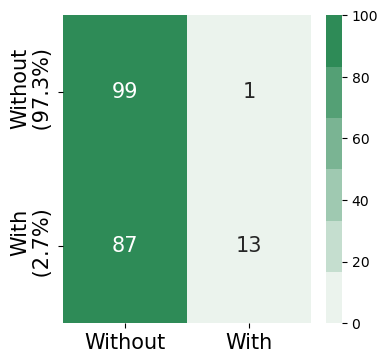

In [92]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(conf_mat * 100, ax=ax, annot=True, cmap=sns.light_palette("seagreen", reverse=False), 
            vmin=0, vmax=100, annot_kws={'fontsize':15})
ax.set_xticks([0.5, 1.5], ['Without', 'With'], size=15)
ax.set_yticks([0.5, 1.5], ['Without\n (97.3%)', 'With\n (2.7%)'], size=15)
plt.show()

In [49]:
(y_true == y_pred).sum() / len(y_true)

0.9734886215615661

In [39]:
# false negative
flag = (y_true == 1) * (y_pred == 0)
indi[flag]

array([24858, 35234,  1111,  6122, 25582, 15485,  2146,  3672,  3604,
       26174, 11685, 40309, 13414, 10592, 17904, 39172,  1678, 22607,
        4568, 13867, 19463,  6603,  4921, 22366, 22253,  4215, 15171,
       25262, 14054,  1077,  5565, 23871,  1185, 11797,  1802, 22844,
       11842, 22034, 25369, 37389, 25452, 11249, 12077, 36126, 12200,
       22781, 12264, 11127, 34969,  3900, 13133, 25385, 11010, 21804,
       12053, 22835, 11516,  7018, 26035,  6683, 31065,  5325,  8713,
       11212,  1562, 11133,  4581, 40239, 31203, 38232,  5735,  6829,
       21460, 11575, 22227, 12301, 17792, 35017,  2069, 10632, 24821,
       25281, 25277,  2241, 17766, 22429,  6158, 38688, 25361,  6707,
         270, 22007, 12873, 12959, 11451, 25528,  4557, 11508, 11925,
        5216, 21846, 25883, 11640,  1726, 21960, 24331,  4170,  3620,
       22284,  1805,   100, 12961, 17774,  8817, 17757, 21654,  1079,
       14095, 25525, 38141, 10633, 25450, 10020,  4225, 11968, 25207,
        4695, 21885,

# false positive
flag = (y_true == 0) * (y_pred == 1)
indi[flag]

In [41]:
# true positive
flag = (y_true == 1) * (y_pred == 1)
indi[flag]

array([26085, 22773,  9862, 21750, 11805, 13083, 23955, 11796, 11989,
       21562,  6584, 10281, 21735, 12081, 21693, 11876, 21721,  8734,
       21484, 21678,  6171, 11515, 21694, 11687, 39599, 21749, 11809,
       14213, 11264, 21611, 11872, 11728, 10158,  7160,  2283, 10616,
       11610, 23817, 11320, 21756,  6374, 39722, 23862, 21567, 11206,
       11521, 22898, 40887, 22254, 21921, 10977, 10653, 30167,  3635,
       21571, 23905,  7041, 39015,  8457, 22874, 38689, 17753, 11529,
       23864, 26131,  9646,  7067, 21995, 29870, 11760, 25284, 11383,
       21450, 21736, 10833, 35634, 11372, 22355,  6062, 21763,  5697,
        4945, 10595, 40603, 39432, 12004, 11310, 11673, 11651, 39791,
       10667, 11627,  6379, 34516, 11768,  3622, 27779, 11950, 39706,
       21547, 10210, 10461, 23808, 24212, 10345, 35502, 22259, 22137,
       25996, 25936, 22092, 21534, 35885,  3707, 11939, 11641,  3611,
       11051, 21812, 40951, 38749, 21582, 22452, 11343,  7070, 13293,
       21602, 39430,

In [45]:
(1 - y_true).sum()

38115

In [48]:
speed = np.loadtxt('./data/road/speed_actual_onehot.txt', delimiter=',')
speed.sum(axis=0).max() / speed.sum(axis=0).sum()

0.7329352563022176

## Road Names

In [3]:
df_easy_features = gpd.read_file('./data/network/network_w_easy_features.shp')

In [6]:
df_easy_features[['GEO_ID', 'LF_NAME']].groupby('LF_NAME').count().sort_values(by='GEO_ID')

,GEO_ID
LF_NAME,
1 Autumn Ave,1
Ln N Queen E Crawford,1
Ln N Queen E Craven,1
Ln N Queen E Brooklyn,1
Ln N Queen E Brookfield,1
...,...
Bathurst St,209
Martin Goodman Trl,216
Yonge St,224


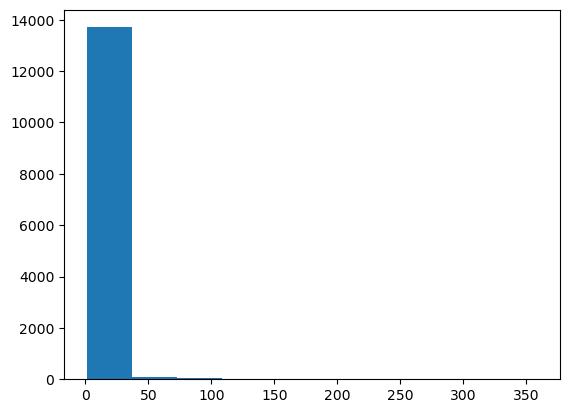

In [10]:
vals = df_easy_features[['GEO_ID', 'LF_NAME']].groupby('LF_NAME').count().sort_values(by='GEO_ID').values
vals = vals.reshape(-1)

plt.hist(vals)
plt.show()

In [11]:
(vals == 1).mean()

0.43845987454034174